# Profit Curves

### Jack Bennetto
#### February 7, 2019

### Objectives

 * Explain why you would use a cost-benefit matrix and profit curve
 * Generate a profit curve and use it to make decisions

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import IPython

Let's start with some (fake) data, with two continuous features and a binary label.

In [2]:
npts = 10000
y = stats.bernoulli(0.2).rvs(npts)
X = pd.DataFrame({'a':stats.norm(0, 1).rvs(npts) + 0.3*y,
                  'b':stats.gamma(3, 2*y).rvs(npts)})

Let's make a graph!

Text(0, 0.5, 'feature b')

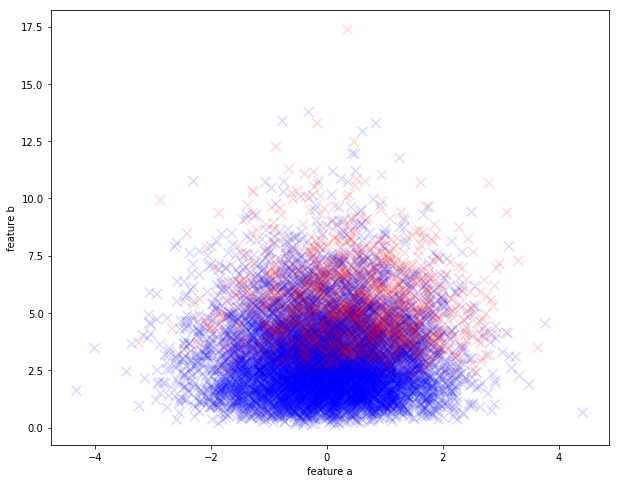

In [3]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(X.a, X.b, marker='x', color=np.array(['b', 'r'])[y], alpha=0.15, s=100)
ax.set_xlabel('feature a')
ax.set_ylabel('feature b')

## Example: Fraud

To make this a little more realistic, let's imagine that you have a website to which people can sign up, and some small fraction of the signups are fraud. You're building a system to detect whether the account is fraudulent.

In [4]:
y = np.array(['Not', 'Fraud'])[y]

Now let's do a train-test split and fit a model. We'll do logistic regression, that's the best classifier we know right now.

In [5]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
model = LogisticRegression()
#model = KNeighborsClassifier(50)
model.fit(Xtrain, ytrain)

/Users/jackbennetto/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Now we predict the results on the test set and see how often we are correct. For the moment we'll use the `predict` method, i.e., assume a 0.5 threshold, not because it's a good choice but just as a starting point.

In [6]:
model.predict(Xtest) == ytest

array([ True, False,  True, ...,  True,  True,  True])

In [7]:
(model.predict(Xtest) == ytest).mean()

0.8076

That's the accuracy.

**Question:** did we do a good job?

## An aside on class balance

We talked briefly about imbalanced classes earlier, situations where there are far more of one class than the other. Ordinarily this isn't an issue, but there are points that do require special consideration.

1. Hard classifiers are particularly problematic with imbalanced classes. They're a problem in general, but if you use a hard classifier it may predict everything to be in the majority class.
2. You should never use accuracy with imbalanced classes. You generally shouldn't use accuracy anyway, but again, it's easy to get a deceptively high accuracy by predicting everything is in the majority class.
3. You should be aware of situations when the class balance of the training data is different than that for which the model will be used in the real world.
4. The ability to predict or infer from your data is more a function of the size of the minority class than the size of all the data.
4. Some people believe other things, and some of them will be interviewing you. They may want you to talk about some of the ways to deal with them. There are a few techniques used to "balance" classes, including **undersampling**, **oversampling**, and **SMOTE**.

Oversampling my be appropriate when the training data doesn't match the actual data, but a class weight is generally better.

Undersampling may be appropriate in cases when you have more data than you can process; in these cases data in the majority class is less important to the result.

End of the aside.

We could look at log loss instead, though it's not all that interpretable either.


Let's consider the full matrix of predicted and actual values.

In [8]:
model.predict(Xtest), ytest

(array(['Not', 'Not', 'Not', ..., 'Not', 'Not', 'Not'], dtype='<U5'),
 array(['Not', 'Fraud', 'Not', ..., 'Not', 'Not', 'Not'], dtype='<U5'))

In [9]:
predicted = model.predict(Xtest)
actual = ytest

In [10]:
pd.crosstab(ytest, model.predict(Xtest), rownames=['actual'], colnames=['predicted'])

predicted,Fraud,Not
actual,,
Fraud,107,389
Not,92,1912


This is interesting, except I want to be able to look at different thresholds. Here are a couple helper functions.

In [11]:
def predict(model, X, threshold=0.5):
    '''Return prediction of the fitted binary-classifier model model on X using
    the specifed `threshold`. NB: class 0 is the positive class'''
    return np.where(model.predict_proba(X)[:, 0] > threshold,
                    model.classes_[0],
                    model.classes_[1])

def confusion_matrix(model, X, threshold=0.5):
    cf = pd.crosstab(ytest, predict(model, Xtest, threshold))
    cf = cf.add(pd.DataFrame([[0,0],[0,0]], columns=['Fraud', 'Not'], index=['Fraud', 'Not']), fill_value=0)
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

In [12]:
confusion_matrix(model, X, 0.5)

predicted,Fraud,Not
actual,,
Fraud,107,389
Not,92,1912


Is that good?

Let's try a couple other thresholds. Which is best?

How do we decide the best value for a threshold?

In [13]:
confusion_matrix(model, X, 0.3)

predicted,Fraud,Not
actual,,
Fraud,256,240
Not,260,1744


In [14]:
confusion_matrix(model, X, 0.4)

predicted,Fraud,Not
actual,,
Fraud,169,327
Not,159,1845


In [15]:
confusion_matrix(model, X, 0.6)

predicted,Fraud,Not
actual,,
Fraud,69,427
Not,54,1950


In [16]:
confusion_matrix(model, X, 0.7)

predicted,Fraud,Not
actual,,
Fraud,35,461
Not,19,1985


## Making hard decisions

In the real world, bad predictions have actual costs, often in money but sometimes in some other metrics (e.g., years of life).

In this case, let's assume that we might want to have a human investigate every account, but that's expensive so we're going to use our model. If the fitted model thinks it's fraud, we have a human investigate; if not we just approve it.

So there are four possibilities:

 * True positive: the account is fraudulent and we flag it for review.
 * True negative: the account is good and we create it automatically.
 * False positive: the account is good but we flag it, so a human has to do some unnecessary work checking the account.
 * False negative: the account is fraud but we let it through. Oops.

We then assign each of these a value, in dollars or whatever. Let's assume that it costs \\$5 to review an account, a good account is worth \\$10 to us, a fraudulent account costs us \\$20, and reviews always catch fraudulent accounts. So we can display all this in a cost-benefit matrix.

**Question:** **This is a big oversimplification.** What assumptions did we make?

**Questions:** what are the values for the various cases?

First, we'll set the default pandas float format so it looks like money.

In [17]:
def currency_format(num):
    if num < 0:
        return f'-${abs(num):,.0f}'
    else:
        return f'${num:,.0f}'
    
pd.options.display.float_format = currency_format

In [18]:
cb_matrix = pd.DataFrame([[-5., -20.], [5., 10.]], columns=["Fraud", "Not"], index=["Fraud", "Not"])
cb_matrix.index.name = 'actual'
cb_matrix.columns.name = 'predicted'

In [19]:
cb_matrix

predicted,Fraud,Not
actual,,
Fraud,-$5,-$20
Not,$5,$10


Remember, the *actual* represents what the user would have done if we hadn't intervened. The *predicted* is what our model predicted the user would do; we use that to decide our action (investigate or not). Those two things together give us an outcome.

Our confusion matrix tells us how many users fit in each category, so to get the overall payout we just multiply things. For example, the total payout from the true positives is the number of true positives times the payout of each one.

In [20]:
confusion_matrix(model, X, 0.3) 

predicted,Fraud,Not
actual,,
Fraud,256,240
Not,260,1744


In [21]:
confusion_matrix(model, X, 0.3) * cb_matrix

predicted,Fraud,Not
actual,,
Fraud,"-$1,280","-$4,800"
Not,"$1,300","$17,440"


And the total payout is the sum of that.

In [22]:
(confusion_matrix(model, X, 0.3) * cb_matrix).values.sum()

12660.0

Let's look at that for a bunch of different values.

In [23]:
for threshold in np.arange(0.0, 1.01, 0.05):
    print("The payout for a threshold of {:3.2f} is ${:>5.0f}".
            format(threshold,
            (confusion_matrix(model, X, threshold) * cb_matrix).values.sum()))

The payout for a threshold of 0.00 is $ 7540
The payout for a threshold of 0.05 is $ 8900
The payout for a threshold of 0.10 is $11760
The payout for a threshold of 0.15 is $13260
The payout for a threshold of 0.20 is $13250
The payout for a threshold of 0.25 is $13115
The payout for a threshold of 0.30 is $12660
The payout for a threshold of 0.35 is $12255
The payout for a threshold of 0.40 is $11860
The payout for a threshold of 0.45 is $11550
The payout for a threshold of 0.50 is $11265
The payout for a threshold of 0.55 is $11065
The payout for a threshold of 0.60 is $10885
The payout for a threshold of 0.65 is $10705
The payout for a threshold of 0.70 is $10550
The payout for a threshold of 0.75 is $10365
The payout for a threshold of 0.80 is $10240
The payout for a threshold of 0.85 is $10180
The payout for a threshold of 0.90 is $10125
The payout for a threshold of 0.95 is $10110
The payout for a threshold of 1.00 is $10120


Question: what should we choose for a threshold?

## The profit curve

We have a bunch of numbers so we'll make a graph.



In [24]:
def calculate_payout(cb_matrix, model, X, threshold):
    return (confusion_matrix(model, X, threshold) * cb_matrix).values.sum()

Text(0.5, 1.0, 'Profit Curve')

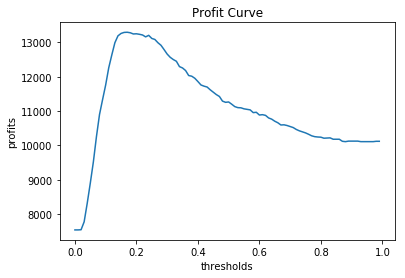

In [25]:
thresholds = np.arange(0.0, 1.0, 0.01)
profits = []
for threshold in thresholds:
    profits.append(calculate_payout(cb_matrix, model, X, threshold))

fig, ax = plt.subplots()
ax.plot(thresholds, profits)
ax.set_xlabel('thresholds')
ax.set_ylabel('profits')
ax.set_title('Profit Curve')

**Question:** What's going on at a threshold of 0?

**Question:** What's going on at a threshold of 1?

**Question:** Why is this jagged?

## Choosing a baseline

It is very common to get confused on cost or benefit of the different boxes. The important thing is to be consistent with the what counts as zero for each of the actual options.

Although there are four degrees of freedom in the cost-benefit matrix, really only two of them affect the shape of the profit curve, as we don't have control of the counts of the actual classes. Suppose, for example, in the old days every single account used to be checked. We want to implement this model to check the accounts first, and only have humans review accounts that it flags. So we want to present to our boss how much money this will save per user, **compared to the old approach.**

In some cases it helps to think of the baseline as a budget, that we have some amount of money we had originally expected to make, and our profit curve is the amount of profit or loss we will make relative to that budget.

In [26]:
cb_matrix2 = cb_matrix + 5
cb_matrix2.iloc[1] -= 10
cb_matrix2

predicted,Fraud,Not
actual,,
Fraud,$0,-$15
Not,$0,$5


**Question:** explain these values.

Let's go back to the original cost-benefit matrix.

**Question:** what's the baseline in the case of Fraud? (i.e., what does \\$0 mean?) What's the baseline in the case of Not-Fraud?

In [27]:
cb_matrix

predicted,Fraud,Not
actual,,
Fraud,-$5,-$20
Not,$5,$10


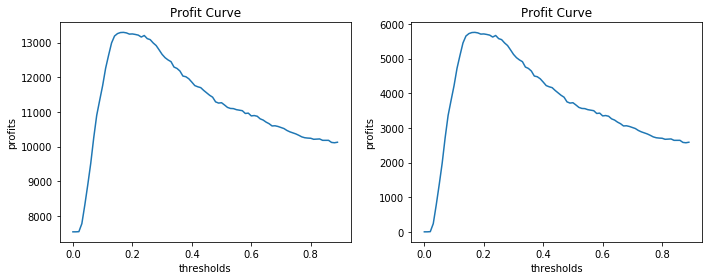

In [28]:
thresholds = np.arange(0.0, 0.9, 0.01)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, matrix in zip(axes, [cb_matrix, cb_matrix2]):
    profits = []
    for threshold in thresholds:
        profits.append(calculate_payout(matrix, model, X, threshold))
    ax.plot(thresholds, profits)
    ax.set_xlabel('thresholds')
    ax.set_ylabel('profits')
    ax.set_title('Profit Curve')
fig.tight_layout()

**Question:** what's the difference between these?

Or maybe we want to make a presentation showing how much fraud is costing the company. We'll see both fraudulent account and investigation as a cost, and we want to create a model to minimize that cost. Then the cost-benefit matrix looks like this.

In [29]:
cb_matrix3 = cb_matrix.copy()
cb_matrix3.iloc[1] -= 10
cb_matrix3

predicted,Fraud,Not
actual,,
Fraud,-$5,-$20
Not,-$5,$0


**Question:** explain these values.

Then our profit curves look like this.

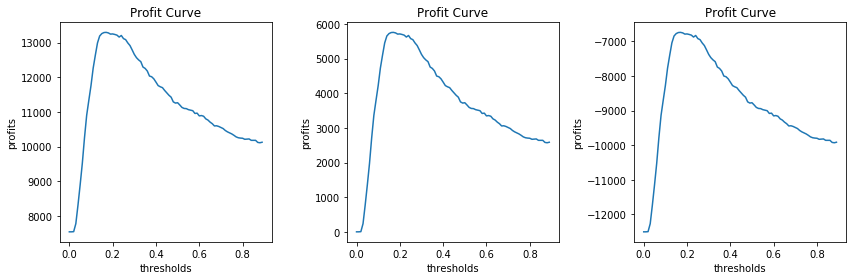

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, matrix in zip(axes, [cb_matrix, cb_matrix2, cb_matrix3]):
    profits = []
    for threshold in thresholds:
        profits.append(calculate_payout(matrix, model, X, threshold))
    ax.plot(thresholds, profits)
    ax.set_xlabel('thresholds')
    ax.set_ylabel('profits')
    ax.set_title('Profit Curve')
fig.tight_layout()

These three graphs have the same overall shape. What do these cost benefit matrices have in common?

**Exercise:** Create another cost-benefit matrix for which the profit curve will have the same shape. 

In [31]:
IPython.display.display(cb_matrix)
IPython.display.display(cb_matrix2)
IPython.display.display(cb_matrix3)

predicted,Fraud,Not
actual,,
Fraud,-$5,-$20
Not,$5,$10


predicted,Fraud,Not
actual,,
Fraud,$0,-$15
Not,$0,$5


predicted,Fraud,Not
actual,,
Fraud,-$5,-$20
Not,-$5,$0
